# Testing Derivative Class

This notebook is where I test my new derivative class. There are two: 

1. This will take a KernelRidge model from a fully trained KRR model from the scikit-learn library that has been trained with my custom RBF kernel.
2. This will take a GP model

In [1]:
import warnings
warnings.simplefilter('ignore')

from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

In [3]:
# cluster = LocalCluster(n_workers=1, 
#                        processes=False)

cluster = SLURMCluster(memory="50GB",
                       env_extra=['export LANG="en_US.utf8"',
                                  'export LANGUAGE="en_US.utf8"',
                                  'export LC_ALL="en_US.utf8"'],
                       cores=1, job_cpu=16, walltime='3:00:00', name='derivative_test')
# cluster = SLURMCluster(processes=1, cores=1, memory="150GB",
#                        job_cpu=24, walltime='3:00:00', name='cross_preds')
cluster.scale(1)
client = Client(cluster)
# client = Client(address="nodo08:3008")
# client = Client(cluster)
address = client.scheduler.address

In [69]:
print(address)

tcp://192.168.2.18:51120


In [70]:
import sys
sys.path.insert(0, '/home/emmanuel/code/kernellib')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from kernellib.kernels import rbf_kernel
from kernellib.krr import KernelRidge
plt.style.use('ggplot')
%matplotlib inline

%load_ext memory_profiler
%load_ext autoreload

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample Data

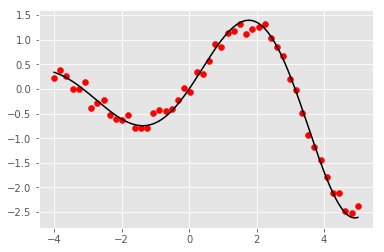

In [71]:
def sample_data():
    """Gets some sample data."""
    d_dimensions = 1
    n_samples = 50
    noise_std = 0.1
    seed = 123
    rng = np.random.RandomState(seed)


    n_train = 50
    n_test = 5000
    xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
    xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)

    f = lambda x: np.sin(x) * np.exp(0.2 * x)
    ytrain = f(xtrain) + noise_std * rng.randn(n_train, 1)
    ytest = f(xtest)

    return xtrain, xtest, ytrain, ytest

random_state = 0
rng = np.random.RandomState(random_state)

xtrain, xtest, ytrain, ytest = sample_data()

fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='r')
ax.plot(xtest, ytest, color='k')

plt.show()

### RBF Kernel Function

In [72]:
from sklearn.gaussian_process.kernels import RBF
from kernellib.kernels import rbf_kernel

%autoreload 2

In [73]:
K = rbf_kernel(xtrain, length_scale=1.0)
sk_rbf_kernel = RBF(length_scale=1.0)
K_sk = sk_rbf_kernel(xtrain)

np.testing.assert_array_almost_equal(K, K_sk, decimal=13)


In [18]:
%timeit -r 10 rbf_kernel(xtrain, xtrain, length_scale=1.0)

135 µs ± 8.45 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [19]:
%timeit -r 10 sk_rbf_kernel(xtrain, xtrain)

85.6 µs ± 2.61 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


In [20]:
X = np.random.randn(5000, 50)

In [21]:
%timeit rbf_kernel(X, length_scale=1.0)

313 ms ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Compiler time: 0.21 s


In [22]:
%timeit sk_rbf_kernel(X)

701 ms ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### With My Custom Kernel Ridge Function

In [74]:
from kernellib.krr import KernelRidge

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
krr_model = KernelRidge(alpha=1.0, length_scale=1.0, signal_variance=1.0)
print(xtrain.shape, ytrain.shape)
krr_model.fit(xtrain, ytrain.reshape(-1,1))
ypred = krr_model.predict(xtest)

(50, 1) (50, 1)


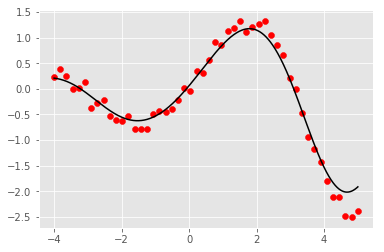

In [76]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='r')
ax.plot(xtest, ypred, color='k')

plt.show()

#### Using Grid Search

In [77]:
from sklearn.model_selection import GridSearchCV

In [78]:
param_grid = {
    'signal_variance': np.logspace(-1, 1, 10),
    'alpha': np.logspace(-3, 1, 10),
    'length_scale': np.logspace(-1, 1, 10)
}

grid_clf = GridSearchCV(KernelRidge(), param_grid=param_grid, verbose=1, n_jobs=8, cv=3)
grid_clf.fit(xtrain, ytrain);
krr_model = grid_clf.best_estimator_
print(krr_model)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 2456 tasks      | elapsed:    3.9s


KernelRidge(alpha=0.001, length_scale=2.1544346900318834,
      signal_variance=1.291549665014884)


[Parallel(n_jobs=8)]: Done 3000 out of 3000 | elapsed:    4.4s finished


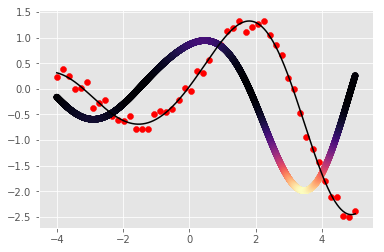

In [79]:
ypred = krr_model.predict(xtest)
der = krr_model.derivative(xtest)
sens = krr_model.sensitivity(xtest)
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, color='r')
ax.plot(xtest, ypred, color='k')
ax.scatter(xtest, der, c=sens.reshape(-1, 1), cmap=plt.get_cmap('magma'))

plt.show()

## Derivative

In [80]:
from kernellib.derivatives import RBFDerivative

%autoreload 2

In [81]:
rbf_derivative = RBFDerivative(krr_model=krr_model)
der = rbf_derivative(xtest)
point_sens = rbf_derivative.sensitivity(xtest)
dim_sens = rbf_derivative.sensitivity(xtest, sample='dim')
print(dim_sens)

[0.86842487]


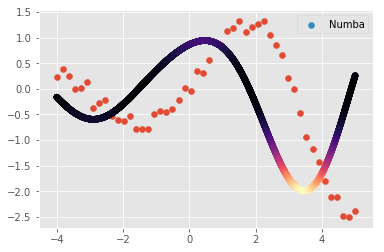

In [82]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain)
# ax.scatter(xtest, der, label='Full')
ax.scatter(xtest, der, c=point_sens.reshape(-1, 1), cmap=plt.get_cmap('magma'), label='Numba')

ax.legend()
plt.show()

## 2D Example

In [83]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [84]:
X, y = load_boston().data, load_boston().target

xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=123)
print(xtrain.shape, xtest.shape)

(404, 13) (102, 13)


In [122]:
%%time 

param_grid = {
    'signal_variance': np.logspace(0, 5, 10),
    'alpha': np.logspace(-5, 5, 10),
    'length_scale': np.logspace(-5, 5, 20)
}

grid_clf = GridSearchCV(KernelRidge(), param_grid=param_grid, verbose=1, n_jobs=12, cv=3)
grid_clf.fit(xtrain, ytrain);
krr_model = grid_clf.best_estimator_
print(krr_model)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    4.9s
[Parallel(n_jobs=12)]: Done 780 tasks      | elapsed:    8.6s
[Parallel(n_jobs=12)]: Done 1680 tasks      | elapsed:   18.4s
[Parallel(n_jobs=12)]: Done 2780 tasks      | elapsed:   31.1s
[Parallel(n_jobs=12)]: Done 4080 tasks      | elapsed:   47.6s
[Parallel(n_jobs=12)]: Done 5580 tasks      | elapsed:  1.1min


KernelRidge(alpha=0.0001291549665014884, length_scale=2636.6508987303555,
      signal_variance=27825.59402207126)
CPU times: user 5.97 s, sys: 1.27 s, total: 7.24 s
Wall time: 1min 9s


[Parallel(n_jobs=12)]: Done 6000 out of 6000 | elapsed:  1.1min finished


In [123]:
ypred = krr_model.predict(xtest)
mse = mean_squared_error(ypred, ytest)
mae = mean_absolute_error(ypred, ytest)
r2 = r2_score(ypred, ytest)
print(mse, mae, r2)

14.336122376903118 2.6499287969925818 0.7989489618878673


In [124]:
from kernellib.derivatives import RBFDerivative

%autoreload 2

In [125]:
rbf_derivative = RBFDerivative(krr_model=krr_model)
der = rbf_derivative(xtest)
point_sens = rbf_derivative.sensitivity(xtest)
dim_sens = rbf_derivative.sensitivity(xtest, sample='dim')

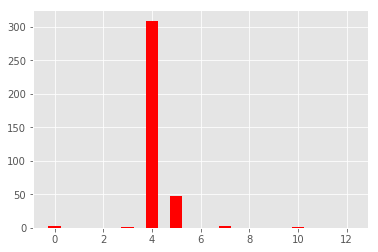

In [126]:
ind = np.arange(X.shape[1])  # the x locations for the groups
width = .5       # the width of the bars

fig, ax = plt.subplots()
gpr = ax.bar(ind, dim_sens, width, color='r', label='ARD')

plt.show()